In [1]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [223]:
percorso_csv = r"../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

              game_id
date                 
2012-07-30  2211607.0
2012-07-30  2211607.0
2012-07-30  2211607.0
2012-07-30  2211607.0
2012-07-30  2211607.0
...               ...
2023-12-04  4227833.0
2023-12-04  4231133.0
2023-12-04  4231133.0
2023-12-04  4231134.0
2023-12-04  4231134.0

[141832 rows x 1 columns]


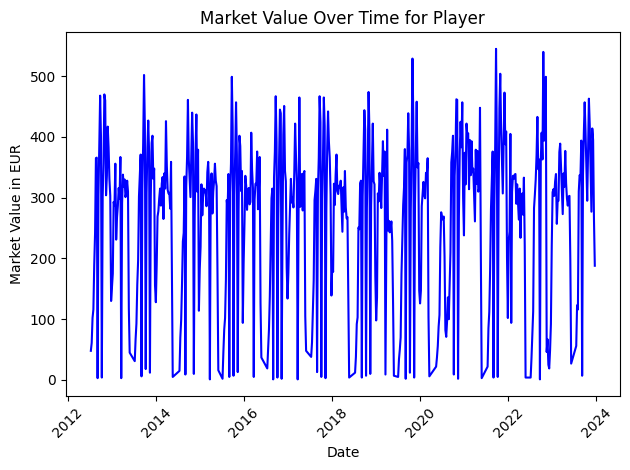

Test Statistic         -7.933885e+00
p-value                 3.454758e-12
Lags                    1.400000e+01
Observations            5.140000e+02
Critical Value (1%)    -3.443136e+00
Critical Value (5%)    -2.867179e+00
Critical Value (10%)   -2.569774e+00
dtype: float64


In [225]:
df_per_previsione_gol = df_game_events[['date', 'game_id']].where(df_game_events["type"] == "Goals").dropna()
#print(df_per_previsione_gol.head())
df_per_previsione_gol['date'] = pd.to_datetime(df_per_previsione_gol['date'])

df_per_previsione_gol['date'] = df_per_previsione_gol['date'].dt.to_period('W').dt.to_timestamp()
#df_per_previsione_gol["date"] = pd.to_datetime(df_per_previsione_gol["date"])

df_per_previsione_gol = df_per_previsione_gol.set_index('date')
print(df_per_previsione_gol)

df_per_previsione_gol_counts = df_per_previsione_gol
df_per_previsione_gol_counts= df_per_previsione_gol.groupby(['date']).size().reset_index(name='goal')
#print(df_per_previsione_gol_counts)
# Crea il plot mondiale supremo
plt.plot(df_per_previsione_gol_counts['date'], df_per_previsione_gol_counts["goal"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Market Value Over Time for Player')
plt.xlabel('Date')
plt.ylabel('Market Value in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig("../images/serie_temp_gol.png")
plt.show()

differenced_series_gol = df_per_previsione_gol_counts
differenced_series_gol = differenced_series_gol.set_index('date')
test_stationarity(differenced_series_gol["goal"])


In [226]:
print(differenced_series_gol)

            goal
date            
2012-07-09    48
2012-07-16    61
2012-07-23   102
2012-07-30   116
2012-08-06   189
...          ...
2023-11-20   277
2023-11-27   414
2023-12-04   395
2023-12-11   266
2023-12-18   188

[529 rows x 1 columns]


In [67]:
#teoricamente non c'è bisogno di differenziare ma lo tengo a disposizizone

# Esegui la differenziazione della serie temporale
differenced_series_gol["diff"] = differenced_series_gol['goal'].diff()

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series_gol["diff"].dropna())


Test Statistic         -9.510273e+00
p-value                 3.263548e-16
Lags                    1.700000e+01
Observations            5.100000e+02
Critical Value (1%)    -3.443237e+00
Critical Value (5%)    -2.867224e+00
Critical Value (10%)   -2.569797e+00
dtype: float64


In [ ]:
#se faccio la differenziazione plot il risultato

plt.plot(differenced_series_gol['date'], differenced_series_gol["diff"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Market Value Over Time for Player')
plt.xlabel('Date')
plt.ylabel('Market Value in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.show()

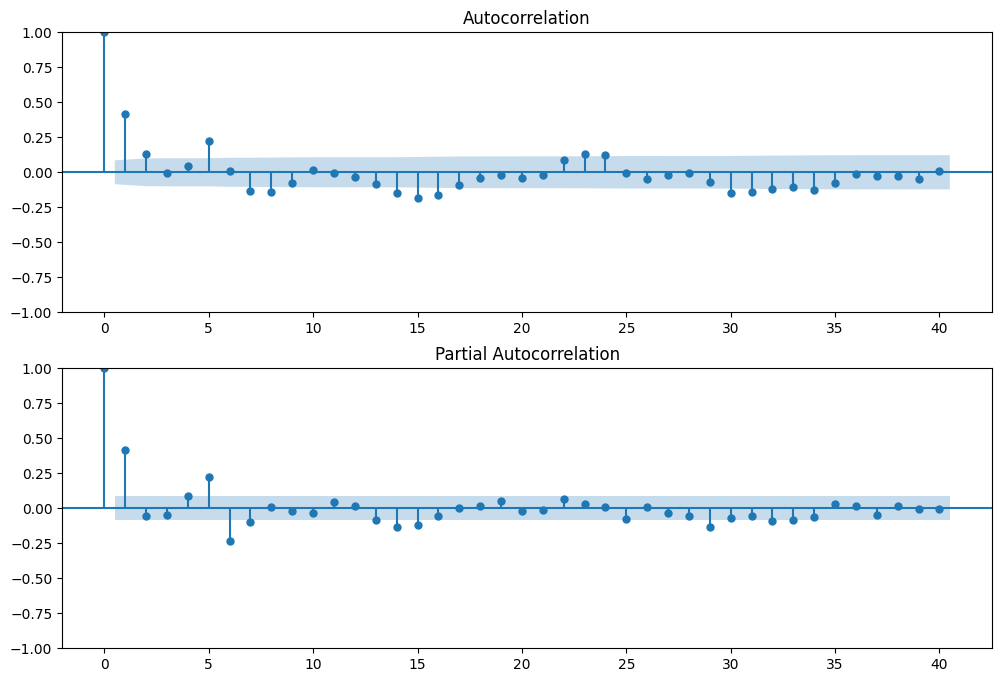

In [227]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(differenced_series_gol["goal"][0:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series_gol["goal"][0:], lags=40, ax=ax2)

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization f

                               SARIMAX Results                                
Dep. Variable:                   goal   No. Observations:                  529
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3289.894
Date:                Thu, 11 Jan 2024   AIC                           6587.788
Time:                        17:16:30   BIC                           6604.872
Sample:                             0   HQIC                          6594.475
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4241      0.025     57.010      0.000       1.375       1.473
ar.L2         -0.4241      0.025    -16.982      0.000      -0.473      -0.375
ma.L1         -0.9977      0.025    -39.678      0.0

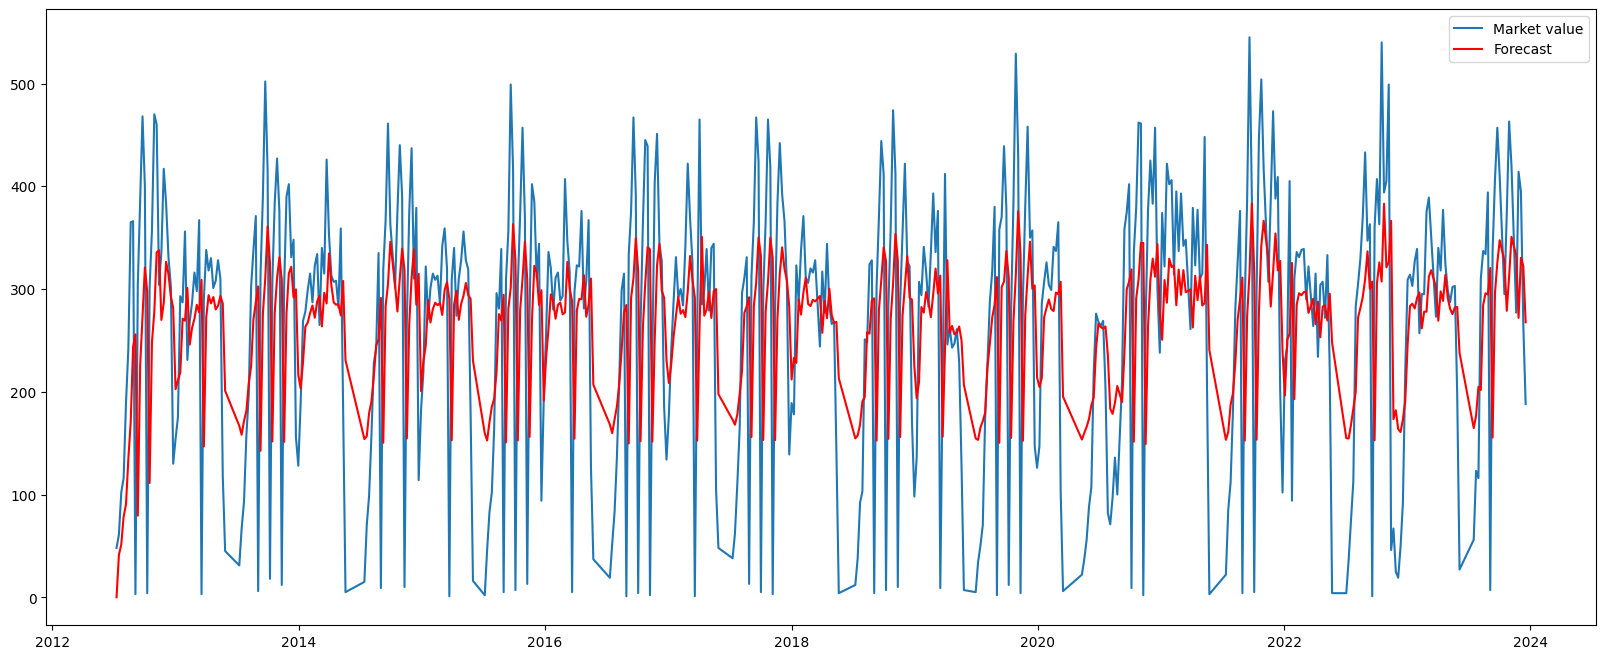

In [249]:
# fit SARIMAX model
fig = plt.figure(figsize=(20,8))
model = SARIMAX(differenced_series_gol["goal"], order=(2,0,1)) 
ax = plt.gca()
results2 = model.fit() 
plt.plot(differenced_series_gol["goal"])
plt.plot(results2.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])

print(results2.summary())


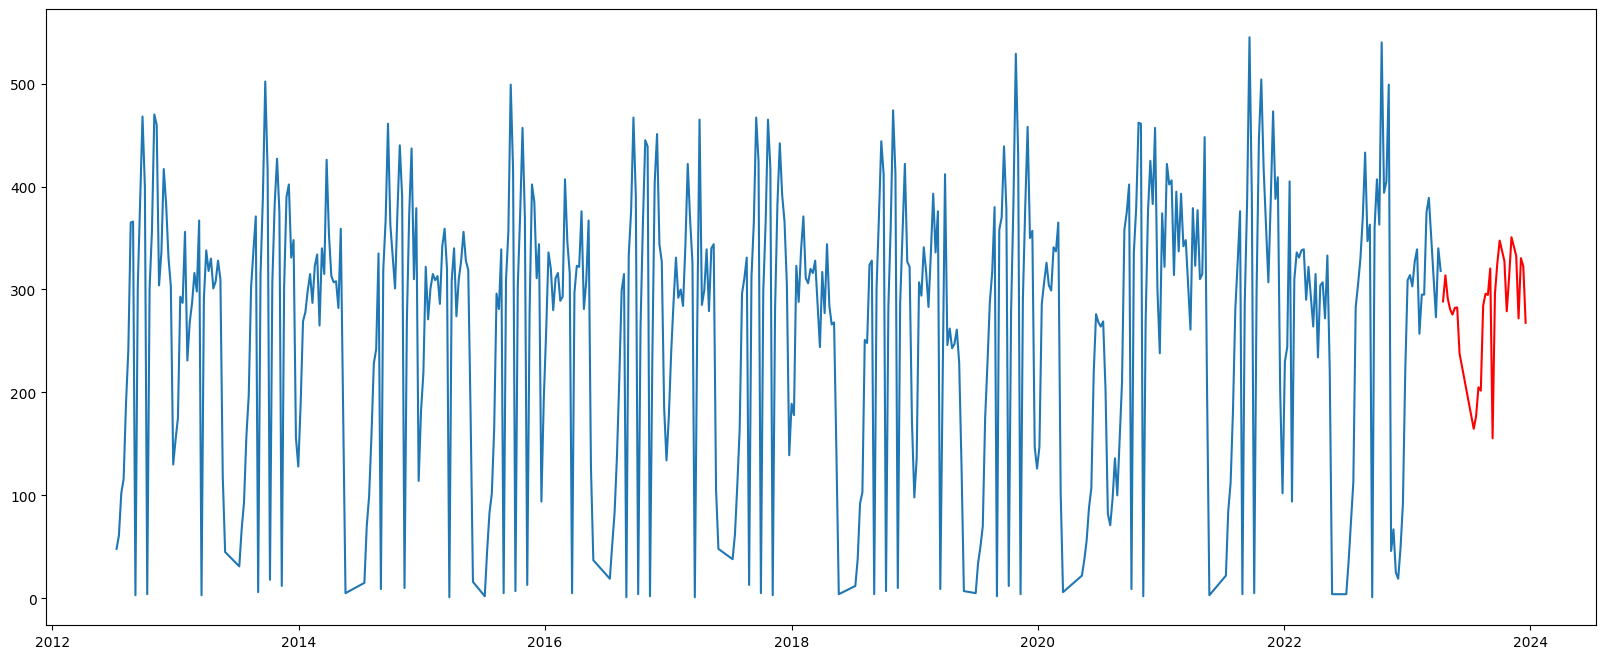

In [300]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series_gol['goal'])
x = results2.predict(start=(500), end=(528), dynamic=False)
plt.plot(differenced_series_gol['goal'][:500])
plt.plot(x, color='r')

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


goal        mean     mean_se  mean_ci_lower  mean_ci_upper
529   234.352857  120.872391      -2.552677     471.258391
530   254.009846  131.420379      -3.569364     511.589057
531   262.345661  133.282729       1.116312     523.575010
532   265.880396  133.638113       3.954507     527.806285
533   267.379090  133.712160       5.308071     529.450109
...          ...         ...            ...            ...
1524  267.941428  134.567892       4.193206     531.689649
1525  267.940882  134.568726       4.191025     531.690738
1526  267.940336  134.569561       4.188844     531.691828
1527  267.939790  134.570395       4.186662     531.692917
1528  267.939244  134.571229       4.184481     531.694006

[1000 rows x 4 columns]


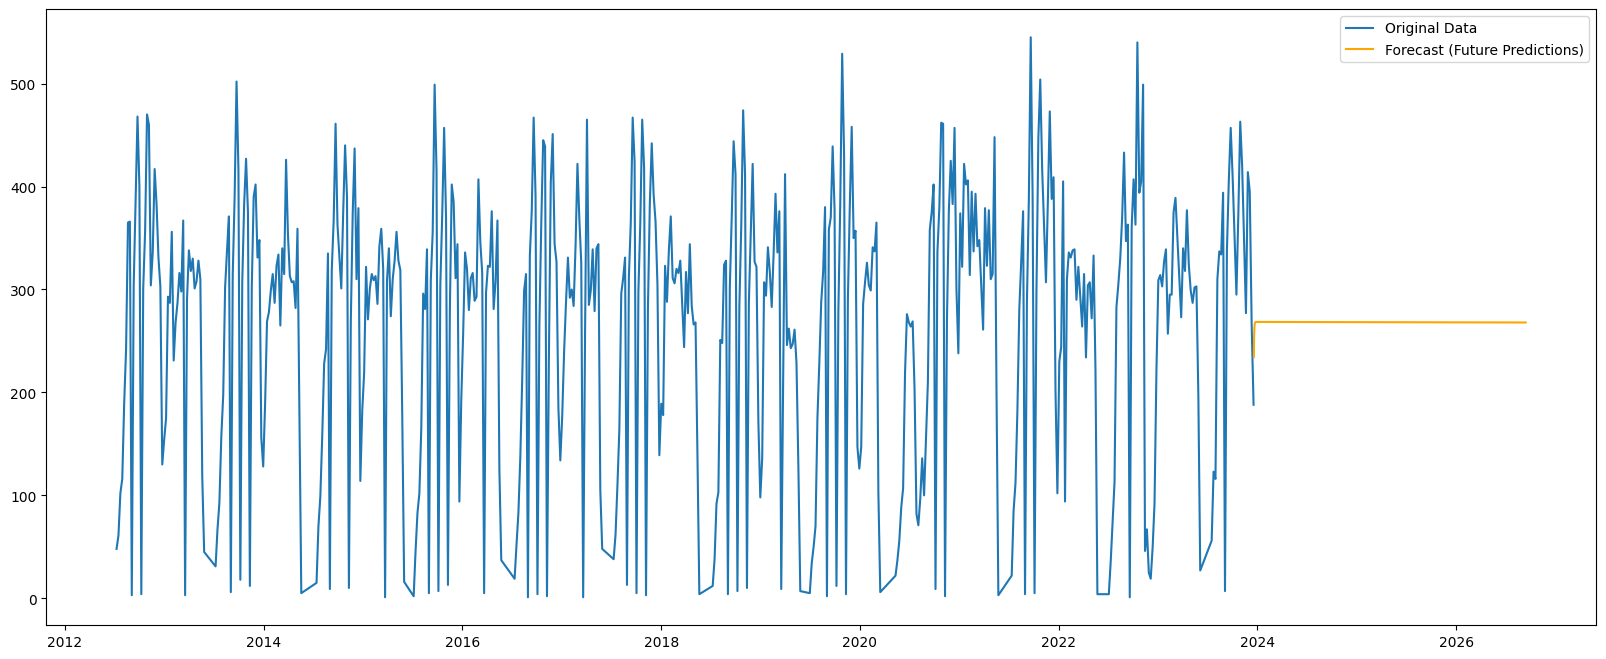

In [315]:
import matplotlib.pyplot as plt

# ... (Assicurati di aver già definito results2 e che i dati siano pronti)

# Calcola le predizioni per periodi futuri (out-of-sample)
future_steps = 1000  # Modifica il numero di passi in base alle tue esigenze
forecast_results = results2.get_forecast(steps=future_steps)
forecast_results2 = results2.get_forecast(steps=future_steps).summary_frame()
print(forecast_results2)

# Estrai le predizioni per periodi futuri
forecast_values = forecast_results.predicted_mean
# Imposta manualmente la frequenza temporale
manual_freq = 'D'  # Modifica in base alla tua frequenza desiderata (es. 'D' per giorni)

# Calcola il passo temporale per la frequenza delle tue date
last_date = differenced_series_gol.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq=manual_freq)
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Original data (assuming your original data is in a variable named 'your_original_data')
ax.plot(differenced_series_gol.index, differenced_series_gol['goal'], label='Original Data')

# Out-of-sample predictions
ax.plot(forecast_index, forecast_results2['mean'], color='orange', label='Forecast (Future Predictions)')

ax.legend()
plt.show()
